<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture 5

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* [Car figure](https://korkortonline.se/en/theory/reaction-braking-stopping/)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the '3dasm' mamba (or conda) environment (see Lecture 1).
2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
    - Note: if you can't pull the repo due to conflicts (and you can't handle these conflicts), use this command (with **caution**!) and your repo becomes the same as the one online:
        ```
        git reset --hard origin/main
        ```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
jupyter notebook
```
5. Open notebook of this Lecture and choose the '3dasm' kernel.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
#plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Bayesian inference for one hidden rv
    - Prior
    - Likelihood
    - Marginal likelihood
    - Posterior
    - Gaussian pdf's product

**Reading material**: This notebook + Chapter 3

## Car distance problem at constant velocity

<img src="../figures/reaction-braking-stopping.svg" title="Car stopping distance" width="25%" align="right">
<br></br>
Our favorite problem at constant velocity $x=75$ m/s is described by:

${\color{red}y} = {\color{blue}z}\cdot 75 + 0.1\cdot 75^2 = 75 {\color{blue}z} + 562.5$

- ${\color{red}y}$ is the **output**: the car stopping distance (in meters)
- ${\color{blue}z}$ is a hidden variable: an <a title="random variable">rv</a> representing the driver's reaction time (in seconds)

where $z \sim \mathcal{N}(\mu_z=1.5,\sigma_z^2=0.5^2)$

In [2]:
# This cell is hidden during presentation. It's just to define a function to plot the governing model of
# the car stopping distance problem. Defining a function that creates a plot allows to repeatedly run
# this function on cells used in this notebook.
def car_fig(ax):
    x = np.linspace(3, 83, 1000)
    mu_z = 1.5; sigma_z = 0.5;  # parameters of the "true" p(z)
    mu_y = mu_z*x + 0.1*x**2 # From Homework of Lecture 4
    sigma_y = np.sqrt( (x*sigma_z)**2 ) # From Homework of Lecture 4
    ax.set_xlabel("x (m/s)", fontsize=20) # create x-axis label with font size 20
    ax.set_ylabel("y (m)", fontsize=20) # create y-axis label with font size 20
    ax.set_title("Car stopping distance problem", fontsize=20); # create title with font size 20
    ax.plot(x, mu_y, 'k:', label="Governing model $\mu_y$")
    ax.fill_between(x, mu_y - 1.9600 * sigma_y,
                    mu_y + 1.9600 * sigma_y,
                    color='k', alpha=0.2,
                    label='95% confidence interval ($\mu_y \pm 1.96\sigma_y$)') # plot 95% credence interval
    ax.legend(fontsize=15)

In [3]:
# This cell is also hidden during presentation.
from scipy.stats import norm # import the normal dist, as we learned before!
def samples_y(N_samples,x): # observations/measurements/samples for car stop. dist. prob.
    mu_z = 1.5; sigma_z = 0.5;
    samples_z = norm.rvs(mu_z, sigma_z, size=N_samples) # randomly draw samples from the normal dist.
    samples_y = samples_z*x + 0.1*x**2 # compute the stopping distance for samples of z
    return samples_y # return samples of y

Empirical mean[y] is 672.5378635093475 (real mean[y]=675)
Empirical std[y] is 35.419420813521 (real std[y]=37.5)


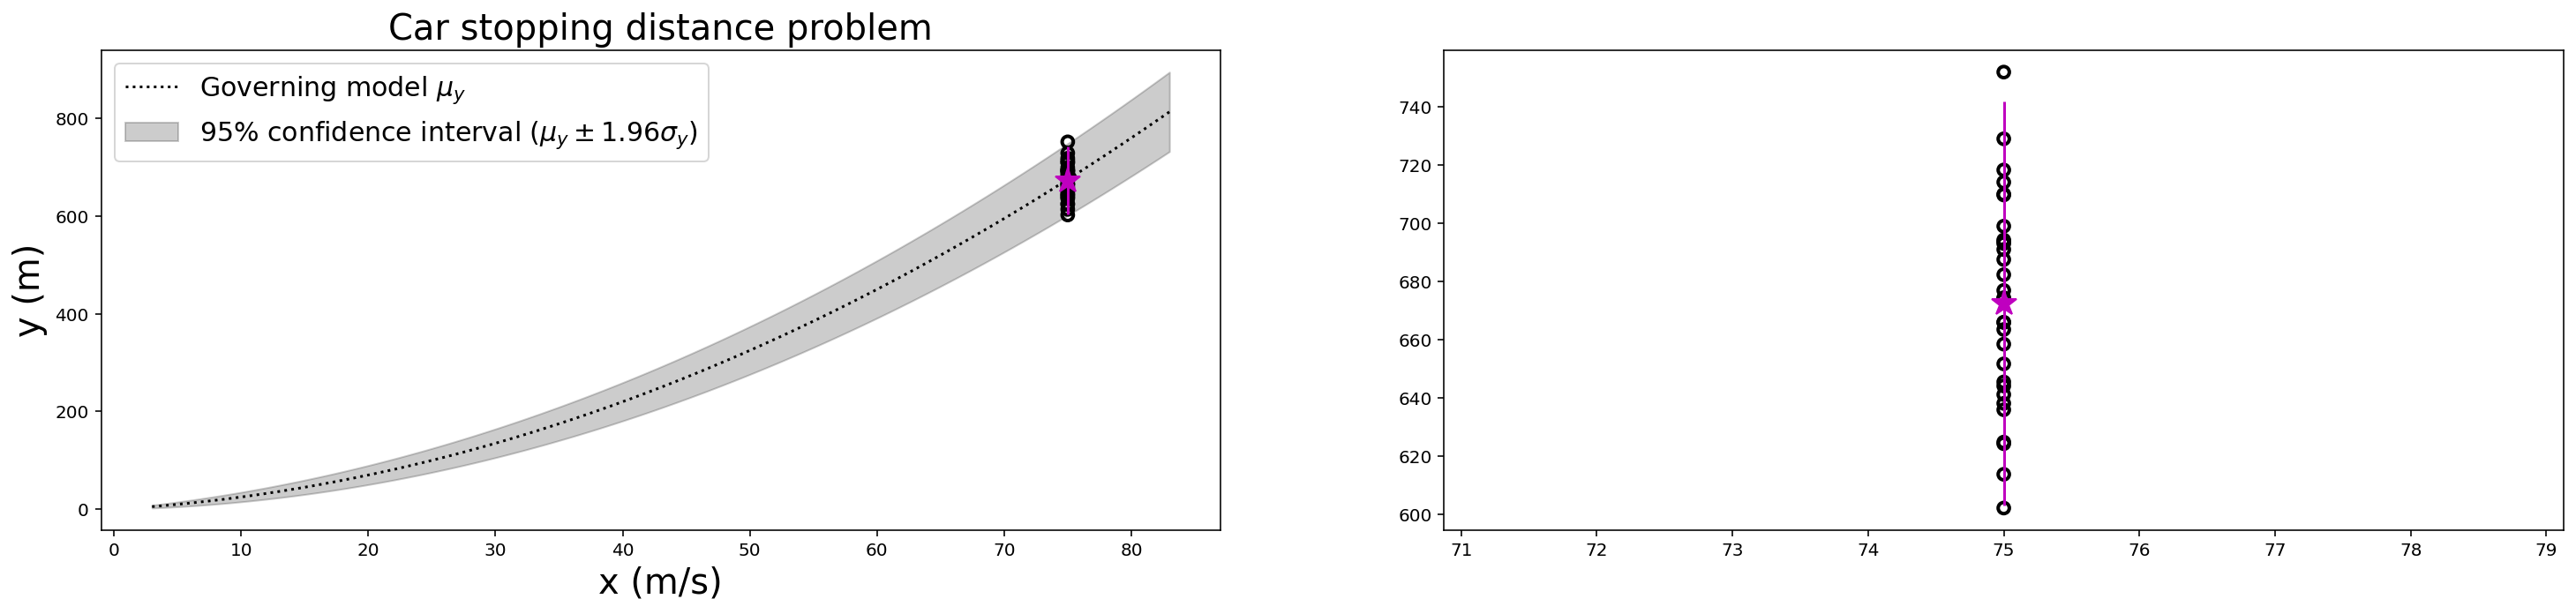

In [9]:
# vvvvvvvvvvv this is just a trick so that we can run this cell multiple times vvvvvvvvvvv
fig_car_new, ax_car_new = plt.subplots(1,2); plt.close() # create figure and close it
if fig_car_new.get_axes():
    del ax_car_new; del fig_car_new # delete figure and axes if they exist
    fig_car_new, ax_car_new = plt.subplots(1,2) # create them again
# ^^^^^^^^^^^ end of the trick ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
N_samples = 3 # CHANGE THIS NUMBER AND RE-RUN THE CELL
x = 75; empirical_y = samples_y(N_samples, x); # Empirical measurements of N_samples at x=75
empirical_mu_y = np.mean(empirical_y); empirical_sigma_y = np.std(empirical_y); # empirical mean and std
car_fig(ax_car_new[0]) # a function I created to include the background plot of the governing model
for i in range(2): # create two plots (one is zooming in on the error bar)
    ax_car_new[i].errorbar(x , empirical_mu_y,yerr=1.96*empirical_sigma_y, fmt='m*', markersize=15);
    ax_car_new[i].scatter(x*np.ones_like(empirical_y),empirical_y, s=40,
                          facecolors='none', edgecolors='k', linewidths=2.0)
print("Empirical mean[y] is",empirical_mu_y, "(real mean[y]=675)")
print("Empirical std[y] is",empirical_sigma_y,"(real std[y]=37.5)")
fig_car_new.set_size_inches(25, 5) # scale figure to be wider (since there are 2 subplots)

### Car stopping distance problem without completely knowing the underlying model

<img src="../figures/reaction-braking-stopping.svg" title="Car stopping distance" width="25%" align="right">

Let's focus (again) on our favorite problem for a constant velocity $x=75$ m/s, **but this time consider the following (more realistic) scenario**:

- Assume that you are **not 100% sure** that the governing model for the stopping distance is: $\require{color}{\color{red}y} = 75{\color{blue}z} + 562.5$. In other words, you **suspect** that the model looks like that but you are not sure that this is the case (it just so happens that you are right!).

- Also, assume that you don't have the slightest idea about the pdf of the reaction time $z$, i.e. you **do not know** that $z \sim \mathcal{N}(\mu_{z}=1.5,\sigma_{z}^2=0.5^2)$.

How can we construct a reasonable joint pdf $p(y,z)$?

### Car stopping distance problem without completely knowing the underlying model

Let's construct a reasonable joint pdf $p(y,z)=p(y|z)p(z)$ by making assumptions about $p(z)$ and $p(y|z)$:

1. Since we have no idea about the pdf of $z$, the simplest assumption we can make is that the prior is the **Uniform distribution** (a.k.a. "noninformative" prior).

2. Since we think that $y = 75 z + 562.5$ but we are not sure, we can assume the conditional pdf to be a Gaussian distribution with **mean** $\mu_{y|z} = 75 z + 562.5$ and with a standard deviation of our choice $\sigma_{y|z} = 80$ m.

    * Note: (for now) this value for the standard deviation can be viewed as a safety margin that we assign to our prediction (it could be any number! I chose 80 because it's close to the actual standard deviation for $y$ when using the actual distribution for $z$ at $x=75$ m/s and that you calculated in Homework 2).

### Prior: our beliefs about the problem

As we said, when we have no clue about what the distribution of the hidden rv $z$ is, then we can use a **Uniform distribution** (a.k.a. uninformative prior).

This distribution assigns equal probability to any value of $z$ within an interval $z \in (z_{min}, z_{max})$.

$$
p(z) = \frac{1}{C_z}
$$

where $C_z = z_{max}-z_{min}$ is the **normalization constant** of the Uniform pdf, i.e. the value that guarantees that $p(z)$ integrates to one.

For the time being, we will not assume any particular values for $z_{max}$ and $z_{min}$. So, we will consider the case when $z_{max}\rightarrow +\infty$ and $z_{min}\rightarrow -\infty$. Mathematically this leads to some indefinition, but it's commonly ignored. If we had some information, we could consider some values for these bounds (e.g. $z_{min} = 0$ seconds would be the limit of the fastest reaction time that is humanly possible, and $z_{max} = 3$ seconds would be the slowest reaction time of a human being).

### Conditional pdf: including a little safety...

<img src="../figures/reaction-braking-stopping.svg" title="Car stopping distance" width="25%" align="right">

Now that we settled on the prior, let's focus on the conditional pdf $p(y|z)$ that we decided to assume to be a Gaussian distribution like this:

$$
p(y|z) = \mathcal{N}\left(y | \mu_{y|z}=w z+b, \sigma_{y|z}^2={\color{red}s}^2\right)
$$

where $w$, $b$ and $s$ are all constants that we defined as:

$w=x=75$

$b=0.1 x^2=562.5$

${\color{red}s}^2=80^2$

* Note: we could have assumed any other values, but of course that would have consequences on our predictions... We will discuss this extensively in the next lectures.

#### Note about our new conditional pdf for the car stopping distance problem without complete knowledge

$$
p(y|z) = \mathcal{N}\left(y | \mu_{y|z}=w z+b, \sigma_{y|z}^2={\color{red}s}^2\right)
$$

- Compare the newly assumed Gaussian conditional pdf $p(y|z)$ with the the conditional pdf we defined previously when we were certain about the stopping distance, $y = w z + b$. As you may recall, when we were certain about it then we used: $p(y|z) = \delta\left(y-(75 z+562.5)\right)$.


- Using the Dirac delta "distribution" is equivalent to considering the Gaussian distribution when the standard deviation goes to zero: ${\color{red}s \rightarrow 0}$.
    - It is also equivalent to the Uniform distribution when the interval shrinks to a point.

### Summary of our Model

1. The **observation distribution** (our conditional pdf):

$$\begin{align}
p(y|z) &= \mathcal{N}\left(y | \mu_{y|z}=w z+b, \sigma_{y|z}^2\right) \\
&= \frac{1}{C_{y|z}} \exp\left[ -\frac{1}{2\sigma_{y|z}^2}(y-\mu_{y|z})^2\right]
\end{align}
$$

where $C_{y|z} = \sqrt{2\pi \sigma_{y|z}^2}$ is the **normalization constant** of the Gaussian pdf, and where $\mu_{y|z}=w z+b$, with $w$, $b$ and $\sigma_{y|z}^2$ being constants, as previously mentioned.

2. and the **prior distribution**: $p(z) = \frac{1}{C_z}$

where $C_z = z_{max}-z_{min}$ is the **normalization constant** of the Uniform pdf, i.e. the value that guarantees that $p(z)$ integrates to one.

### So, how can we make our prediction for the car stopping distance problem at constant velocity?

<img src="../figures/reaction-braking-stopping.svg" title="Car stopping distance" width="25%" align="right">

Today we will start making our first prediction!

Recall that we want to predict the stopping distance $y$ at constant velocity $x=75$ m/s without knowing $p(z)$ and without being certain about the stopping distance model.

* So, **how** can we predict $y$ without this information?

Yes!! If we use **Bayes' rule** (and another step... in the next lecture)!

### Understanding the Bayes' rule

$\require{color}$
$$
{\color{green}p(z|y)} = \frac{ {\color{blue}p(y|z)}{\color{red}p(z)} } {p(y)}
$$

* ${\color{red}p(z)}$ is the **prior distribution**
* ${\color{blue}p(y|z)}$ is the **observation distribution** (conditional pdf)
* $p(y)$ is the **marginal distribution**
* ${\color{green}p(z|y)}$ is the **posterior distribution**

### A note about the term "distribution"

The term distribution can mean two things:
1. For **continuous** <a title="random variables">rv's</a>, the term *distribution* means *probability density function* (<a title="probability density function">pdf</a>).

2. For **discrete** <a title="random variables">rv's</a> the term *distribution* means *probability mass function* (<a title="probability mass function">pmf</a>), as we will see later in the course.

We won't talk about categorical distributions or <a title="probability mass functions">pmf's</a> for a while. So, for now, when you see the term *distribution* it is the same as saying <a title="probability density function">pdf</a>.

### Posterior from Bayes' rule

Since we have defined the **observation distribution** and the **prior distribution**, we can now compute the posterior distribution from Bayes' rule.

But this requires a bit of algebra... Let's do it!

First, in order to apply Bayes' rule $p(z|y) = \frac{ p(y|z)p(z)}{p(y)}$ we need to calculate $p(y)$.

$p(y)$ is obtained by marginalizing the joint distribution wrt $z$:

$
p(y) = \int p(y|z)p(z) dz
$

which implies an integration over $z$. So, let's rewrite $p(y|z)$ so that the integration becomes easier.

$$\begin{align}
p(y|z) &= \mathcal{N}\left(y | \mu_{y|z}=w z+b, \sigma_{y|z}^2\right) \\
&= \frac{1}{C_{y|z}} \exp\left[ -\frac{1}{2\sigma_{y|z}^2}(y-(w z+b))^2\right] \\
&= \frac{1}{C_{y|z}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\} \\
&= \frac{1}{|w|}\frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\}
\end{align}
$$

Note: This Gaussian pdf $\mathcal{N}\left(z | \frac{y-b}{w}, \left(\frac{\sigma_{y|z}}{w}\right)^2\right)$ is unnormalized when written wrt $z$ (due to $\frac{1}{|w|}$).

We can now calculate the marginal distribution $p(y)$:

$$
\begin{align}
p(y) &= \int p(y|z)p(z) dz \\
&= \int \frac{1}{|w|}\frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\} \frac{1}{C_z} dz
\end{align}
$$

We can rewrite this expression as,

$$\require{color}
\begin{align}
p(y) &= \frac{1}{|w|\cdot C_z} {\color{blue}\int \frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\} dz} \\
\end{align}
$$

What is the result for the <font color='blue'>blue term</font>?

From where we conclude that the marginal distribution is:

$$\require{color}
p(y) = \frac{1}{|w| C_z }
$$

So, now we can determine the <font color='green'>posterior</font>:

$$\require{color}
\begin{align}
{\color{green}p(z|y)} &= \frac{ p(y|z)p(z)}{p(y)} \\
&= |w| C_z \cdot \frac{1}{|w|}\frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\} \cdot \frac{1}{C_z}\\
&= \frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}}\exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\}
\end{align}
$$

which is a **normalized** Gaussian pdf in $z$: $\mathcal{N}\left(z | \frac{y-b}{w}, \left(\frac{\sigma_{y|z}}{w}\right)^2\right)$

* **This is what the Bayes' rule does!** Computes the posterior ${\color{green}p(z|y)}$ from $p(y|z)$ and $p(z)$.

## Why should we care about the Bayes' rule?

There are a few reasons:

1. As we will see, models are usually (always?) wrong.


2. But our beliefs may help to get closer to reality! Bayes' rule enables us to get better models if our beliefs are reasonable and we don't have lots of data!


3. We don't observe distributions. We observe **DATA**. Bayes' rule is a very powerful way to predict the distribution of our quantity of interest (here: $y$) from data!

## Bayes' rule applied to observed data

Previously, we already introduced Bayes' rule when applied to observed data $\mathcal{D}_y$.

$\require{color}$
$$
{\color{green}p(z|y=\mathcal{D}_y)} = \frac{ {\color{blue}p(y=\mathcal{D}_y|z)}{\color{red}p(z)} } {p(y=\mathcal{D}_y)} = \frac{ {\color{magenta}p(y=\mathcal{D}_y, z)} } {p(y=\mathcal{D}_y)}
$$

* ${\color{red}p(z)}$ is the **prior** distribution
* ${\color{blue}p(y=\mathcal{D}_y|z)}$ is the **likelihood** function
* ${\color{magenta}p(y=\mathcal{D}_y, z)}$ is the **joint likelihood** (product of likelihood function with prior distribution)
* $p(y=\mathcal{D}_y)$ is the **marginal likelihood**
* ${\color{green}p(z|y=\mathcal{D}_y)}$ is the **posterior**

We can write Bayes' rule as <font color='green'>posterior</font> $\propto$ <font color='blue'>likelihood</font> $\times$ <font color='red'>prior </font>, where we are ignoring the denominator $p(y=\mathcal{D}_y)$ because it is just a **constant** independent of the hidden variable $z$.

## Bayes' rule applied to observed data

But remember that Bayes' rule is just a way to calculate the posterior:

$$
p(z|y=\mathcal{D}_y) = \frac{ p(y=\mathcal{D}_y|z)p(z) } {p(y=\mathcal{D}_y)}
$$

Usually, what we really want is to be able to predict the distribution of the quantity of interest (here: $y^*$) after observing some data $\mathcal{D}_y$:

$$\require{color}
{\color{orange}p(y^*|y=\mathcal{D}_y)} = \int p(y^*|z) p(z|y=\mathcal{D}_y) dz
$$

which is often written in simpler notation: $p(y^*|\mathcal{D}_y) = \int p(y^*|z) p(z|\mathcal{D}_y) dz$

### Bayesian inference for car stopping distance problem

Now we will solve the first Bayesian ML problem from some given data $y=\mathcal{D}_y$:

| $y_i$ (m) |
| ---- |
| 601.5 |
| 705.9 |
| 693.8 |
| ...   |
| 711.3 |

where the data $\mathcal{D}_y$ could be a Pandas dataframe with $N$ data points ($N$ rows).

* **Very Important Question (VIQ)**: Can we calculate the **likelihood** function from this data?

### Likelihood for car stopping distance problem

Of course! As we saw a few cells ago, the **likelihood** is obtained by evaluating the **observation distribution** at the data $\mathcal{D}_y$.

Noting that each observation in $\mathcal{D}_y$ is independent of each other and that they have the same distribution (**indepentent and identically distributed**: i.i.d.), then:

$$
p(y=\mathcal{D}_y | z) = \prod_{i=1}^{N} p(y=y_i|z) = p(y=y_1|z)p(y=y_2|z) \cdots p(y=y_N|z)
$$

which gives the **probability density** of observing that data if using our observation distribution (part of our model!).

#### Calculating the likelihood

Let's calculate it:

$$
\begin{align}
p(y=\mathcal{D}_y | z) &= \prod_{i=1}^{N} p(y=y_i|z) \\
&= \prod_{i=1}^{N} \frac{1}{|w|}\frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y_i-b}{w}\right)\right]^2\right\} \\
&= \prod_{i=1}^{N} \frac{1}{|w|} \mathcal{N}\left(z|\mu_i, \sigma_i^2\right)
\end{align}
$$

where $\mu_i = \frac{y_i-b}{w}$ and $\sigma_i =\frac{\sigma_{y|z}}{w}$

This seems a bit daunting... I know. Do not dispair yet!

##### Product of Gaussian pdf's of the same rv $z$

It can be shown that the product of $N$ univariate Gaussian pdf's of the same rv $z$ is:

$$
\prod_{i=1}^{N} \mathcal{N}(z|\mu_i, \sigma_i^2) = C \cdot \mathcal{N}(z|\mu, \sigma^2)
$$

with mean: $\mu = \sigma^2 \left( \sum_{i=1}^{N} \frac{\mu_i}{\sigma_i^2}\right)$

variance: $\sigma^2= \frac{1}{\sum_{i=1}^{N} \frac{1}{\sigma_i^2}}$

and normalization constant: $C = \frac{1}{\left(2\pi\right)^{(N-1)/2}}\sqrt{\frac{\sigma^2}{\prod_{i=1}^N \sigma_i^2}} \exp\left[-\frac{1}{2}\left(\sum_{i=1}^{N} \frac{\mu_i^2}{\sigma_i^2} - \frac{\mu^2}{\sigma^2}\right)\right]$

Curiosity: the normalization constant $C$ is itself a Gaussian! You can see it more clearly if you consider $N=2$

Note that the normalization constant shown in the previous cell can also be written as:

$$
C = \frac{1}{\left(2\pi\right)^{(N-1)/2}}\sqrt{\frac{\sigma^2}{\prod_{i=1}^N \sigma_i^2}} \exp\left[-\frac{1}{2}\left(\sum_{i=1}^{N-1}\sum_{j=i+1}^{N} \frac{(\mu_i-\mu_j)^2}{\sigma_i^2 \sigma_j^2}\sigma^2\right)\right]
$$

## In Homework 3...

Show that the product of two Gaussian <a title="probability density functions">pdf's</a> for the same <a title="random variable">rv</a> $z$ is:

$\mathcal{N}(z|\mu_1, \sigma_1^2)\cdot \mathcal{N}(z|\mu_2, \sigma_2^2)= C \cdot \mathcal{N}(z | \mu, \sigma^2)$

$$
\begin{align}
\sigma^2&=\frac{1}{\frac{1}{\sigma_1^2}+\frac{1}{\sigma_2^2}}\\
\mu&=\sigma^2\left(\frac{\mu_1}{\sigma_1^2} +  \frac{\mu_2}{\sigma_2^2}\right)\\
C &= \frac{1}{\sqrt{2\pi(\sigma_1^2+\sigma_2^2)}} \exp\left[-\frac{1}{2(\sigma_1^2+\sigma_2^2)}(\mu_1-\mu_2)^2\right]
\end{align}
$$

#### Side note

It's interesting to note that the product of MVN's for the same rv's $\mathbf{z}$ is also a Gaussian!

To keep things simple, here's the result for the product of 2 Gaussian pdf's:

$\mathcal{N}(\mathbf{z}|\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)\cdot \mathcal{N}(\mathbf{z}|\boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2)= C \cdot \mathcal{N}(\mathbf{z} | \boldsymbol{\mu}, \boldsymbol{\Sigma})$

where

$\boldsymbol{\mu} = \boldsymbol{\Sigma}\left(\boldsymbol{\Sigma}_1^{-1}\boldsymbol{\mu}_1 + \boldsymbol{\Sigma}_2^{-1}\boldsymbol{\mu}_2 \right)$

$\boldsymbol{\Sigma} = \left( \boldsymbol{\Sigma}_1^{-1}+\boldsymbol{\Sigma}_2^{-1}\right)^{-1}$

$
\begin{align}
C &= \mathcal{N}_{\boldsymbol{\mu}_1}\left(\boldsymbol{\mu}_2, \left( \boldsymbol{\Sigma}_1+\boldsymbol{\Sigma}_2\right)\right)\\
&= \frac{1}{\sqrt{\det[2\pi \left( \boldsymbol{\Sigma}_1+\boldsymbol{\Sigma}_2 \right)]}} \exp\left[-\frac{1}{2} \left( \boldsymbol{\mu}_1-\boldsymbol{\mu}_2\right)^T\cdot\left( \boldsymbol{\Sigma}_1+\boldsymbol{\Sigma}_2 \right)^{-1}\left( \boldsymbol{\mu}_1-\boldsymbol{\mu}_2 \right) \right]\\
\end{align}
$

#### Back to calculating the likelihood

$$
\begin{align}
p(y=\mathcal{D}_y | z) &= \prod_{i=1}^{N} p(y=y_i|z) \\
&= \prod_{i=1}^{N} \frac{1}{|w|} \frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y_i-b}{w}\right)\right]^2\right\} \\
&= \frac{1}{|w|^N} \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y_i-b}{w}\right)\right]^2\right\}
\end{align}
$$

So, using the result of a product of $N$ Gaussian pdf's to calculate the likelihood, and noting that $\sigma_i = \frac{\sigma_{y|z}}{w}$ and $\mu_i = \frac{y_i - b}{w}$ we get:

$$
p(y=\mathcal{D}_y | z) = \frac{1}{|w|^N} \cdot C \cdot \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left[ -\frac{1}{2\sigma^2}(z-\mu)^2\right]
$$

where

$\mu = \frac{\sigma^2}{\sigma_i^2} \sum_{i=1}^N \mu_i = \frac{w^2\sigma^2}{\sigma_{y|z}^2} \sum_{i=1}^N \mu_i$

$\sigma^2 = \frac{1}{ \sum_{i=1}^N \frac{1}{\sigma_i^2} } = \frac{1}{ \sum_{i=1}^N \frac{w^2}{\sigma_{y|z}^2} } = \frac{\sigma_{y|z}^2}{w^2 N}$

$
C = \frac{1}{\left(2\pi\right)^{(N-1)/2}} \sqrt{\frac{\sigma^2}{\left( \frac{\sigma_{y|z}^2}{w^2}\right)^N}} \exp\left[-\frac{1}{2}\left(\frac{w^2}{\sigma_{y|z}^2}\sum_{i=1}^N \mu_i - \frac{\mu^2}{\sigma^2}\right) \right] = \frac{1}{\left(2\pi\right)^{(N-1)/2}} \sqrt{\frac{\sigma^2}{\left( \frac{\sigma_{y|z}^2}{w^2}\right)^N}} 
$

#### Calculating the marginal likelihood

$$\begin{align}
p(y=\mathcal{D}_y) &= \int p(y=\mathcal{D}_y | z) p(z) dz \\
&= \int \frac{1}{|w|^N} C \cdot \mathcal{N}(z|\mu, \sigma^2)\cdot \frac{1}{C_z} dz\\
&= \frac{C}{|w|^N C_z} \int \mathcal{N}(z|\mu, \sigma^2)dz = \frac{C}{|w|^N C_z} \\
\end{align}
$$

We can now calculate the posterior:

$$\begin{align}
p(z|y=\mathcal{D}_y) &= \frac{ p(y=\mathcal{D}_y|z)p(z) } {p(y=\mathcal{D}_y)} \\
&= \frac{1}{p(y=\mathcal{D}_y)} \cdot \frac{1}{|w|^N} C \cdot \mathcal{N}(z|\mu,\sigma^2) \cdot \frac{1}{C_z} \\
&= \mathcal{N}(z|\mu, \sigma^2)
\end{align}
$$

#### Calculating the Posterior Predictive Distribution (PPD)

Having found the posterior, we can determine the PPD:

$$
p(y^*|\mathcal{D}_y) = \int p(y^*| z) p(z|\mathcal{D}_y) dz
$$

To calculate this, we will have to use the identity for a product of two Gaussians.

$$
\begin{align}
p(y^*|\mathcal{D}_y) &= \int \frac{1}{|w|} \mathcal{N}\left(z|\frac{y^*-b}{w}, \left(\frac{\sigma_{y|z}}{w}\right)^2\right) \mathcal{N}(z|\mu, \sigma^2) dz \\
&= \int \frac{1}{|w|} C^* \mathcal{N}\left(z|\mu^*, \left(\sigma^*\right)^2\right) dz \\
\end{align}
$$

#### Calculating the Posterior Predictive Distribution (PPD)

We can find these parameters from the identity for a product of two Gaussians.

$$
p(y^*|\mathcal{D}_y) = \int \frac{1}{|w|} C^* \mathcal{N}\left(z|\mu^*, \left(\sigma^*\right)^2\right) dz
$$

where

$\mu^* = \left(\sigma^* \right)^2 \left( \frac{\mu}{\sigma^2} + \frac{(y^*-b)/w}{\left(\frac{\sigma_{y|z}}{w}\right)^2} \right) = \left(\sigma^* \right)^2 \left( \frac{\mu}{\sigma^2} + \frac{(y^*-b)\cdot w}{\sigma_{y|z}^2} \right)$

$\left( \sigma^* \right)^2 = \frac{1}{\frac{1}{\sigma^2}+\frac{1}{\left( \frac{\sigma_{y|z}}{w}\right)^2}}= \frac{1}{\frac{1}{\sigma^2}+\frac{w^2}{\sigma_{y|z}^2}}$

$C^* = \frac{1}{\sqrt{2\pi \left( \sigma^2 + \frac{\sigma_{y|z}^2}{w^2} \right)}}\exp\left[ - \frac{\left(\mu - \frac{y^*-b}{w}\right)^2}{2\left( \sigma^2+\frac{\sigma_{y|z}^2}{w^2}\right)}\right]$

## Next class

In the next class we will finish this example, by solving this integral to determine the PPD $p(y^*|\mathcal{D}_y)$.

### See you next class

Have fun!